# Visualize LDA distribution


### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import ternary

### Define the Dirichlet PDF as a $\Gamma$ distribution with parameters set by $\alpha$

This Dirichlet function (though could be taken from scipy) is taken from:

http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

In [2]:
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

### Setting up contour plot and triangle in matplotlib

These functions are also taken from:

http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

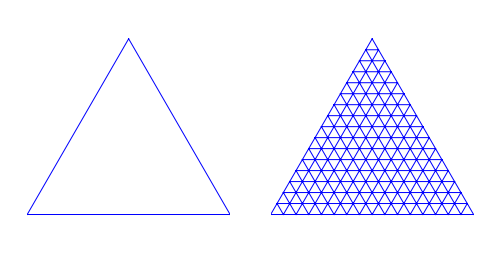

In [3]:
# The corners of the triangle go from 0 to 1 on a side, and up to sqrt(3)/2
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# Set up the grids
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

# Check out a very rough mesh
plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')

# Mid-points of triangle sides opposite of each corner
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

### Visualizing the Dirichlet distribution.

The alpha's are the tunable parameter here. Set them to whatever.

There are three plots below:
1. Plot 1 - The contour plot on the mesh showing the PDF on the simplex
2. Plot 2 - We sampled 1000 from the the Dirichlet process
3. Plot 3 - Plotting the theta values resulting from the Dirichlet process

Projecting into 2D space from 3D is difficult. We assume x+y+z=1. See the code at:
https://github.com/marcharper/python-ternary/blob/master/ternary/helpers.py
for more information.

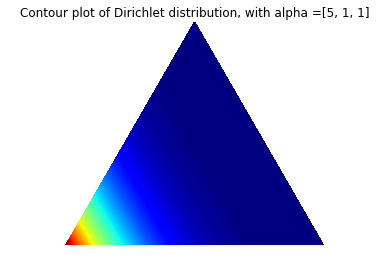

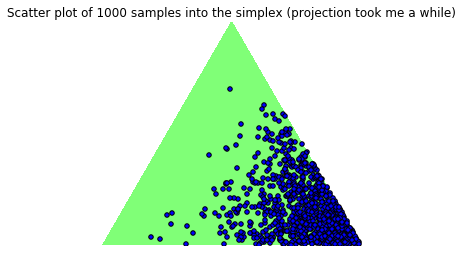

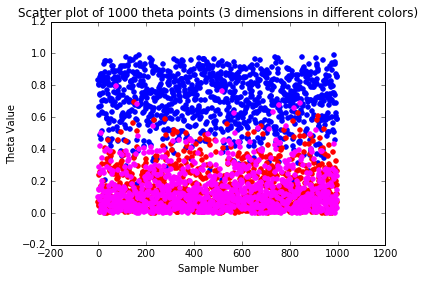

In [5]:
alphas = [5,1,1]

# Draw Dirichlet distribution on mesh with finely sampled points
draw_pdf_contours(Dirichlet(alphas))
plt.title('Contour plot of Dirichlet distribution, with alpha ='+str(alphas))

# Scatter plot drawn from samples
plt.figure()
samps = np.random.dirichlet( alphas, size=1000 )
draw_pdf_contours(Dirichlet([1, 1, 1]))
plt.scatter( (samps.T[0] + samps.T[1]/2.0), np.sqrt(3)/2*samps.T[1] )
plt.title('Scatter plot of 1000 samples into the simplex (projection took me a while)')

# Scatter sample of points
plt.figure()
plt.scatter(range(samps.shape[0]), samps[:,0],color='blue')
plt.scatter(range(samps.shape[0]), samps[:,1],color='red')
plt.scatter(range(samps.shape[0]), samps[:,2],color='magenta')
plt.xlabel('Sample Number')
plt.ylabel('Theta Value')
plt.title('Scatter plot of 1000 theta points (3 dimensions in different colors)')